# Logistic Regression

# 假设某一课程成绩的是由多个因素决定，其中平时成绩和期末成绩两部分起到决定性作用，只有满足条件，才能得到优秀

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import datetime
import random
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
%matplotlib inline

先随机生成一些数

In [58]:
lower, upper = 0, 100
mu1, sigma1 = 90, 10
mu2, sigma2 = 85, 10

X1 = stats.truncnorm(
    (lower - mu1) / sigma1, (upper - mu1) / sigma1, loc=mu1, scale=sigma1)#有区间限制的随机数

X2 = stats.truncnorm(
    (lower - mu2) / sigma2, (upper - mu2) / sigma2, loc=mu2, scale=sigma2)#有区间限制的随机数

x1 = X1.rvs(1000)
x2 = X2.rvs(1000)
y = np.zeros(1000)
for i in range(len(x1)):
    
    if(0.4*x1[i]+0.6*x2[i])+random.randint(0,5)>92:
        y[i] = 1
    if x2[i]>98 or x1[i]>98:
        y[i] = 1
    if x2[i]<60 or x1[i]<60:
        y[i] = 0

X = []
c = zip(x1,x2)
X = np.array(list(c))
X[:,1] = ((X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1])))
pdData = pd.DataFrame(X,columns=['x1','x2'])
pdData.insert(len(X[0]),'Y',y)

In [59]:
pdData.shape

(1000, 3)

Text(0, 0.5, '期末成绩')

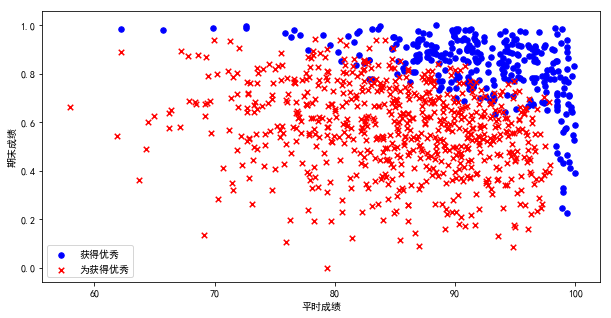

In [60]:
positive = pdData[pdData['Y'] == 1]
negative = pdData[pdData['Y'] == 0]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['x1'], positive['x2'], s=30, c='b', marker='o', label='获得优秀')
ax.scatter(negative['x1'], negative['x2'], s=30, c='r', marker='x', label='为获得优秀')
ax.legend()
ax.set_xlabel('平时成绩')
ax.set_ylabel('期末成绩')

In [61]:

pdData.insert(0, 'Ones', 1) 

orig_data = pdData.as_matrix() 
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

theta = np.zeros([1, 3])

In [62]:
X.shape, y.shape, theta.shape

((1000, 3), (1000, 1), (1, 3))

In [63]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:,1:3] = pp.scale(orig_data[:,1:3])

## The logistic regression

建立logistic分类器（因为有两维特征，所以目标求解出三个参数 $\theta_0         \theta_1         \theta_2 $）



sigmoid : 映射到概率的函数

model : 返回预测结果

predict: 预测结果（根据阈值判断）

loss : 计算损失

reset: 打乱数据

gradient : 计算梯度

descent : 参数更新

accuracy: 计算精度并绘制confusion matrix图




###  `sigmoid` 函数

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [64]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [65]:
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

### 损失函数
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [66]:
def loss(X, y, theta):
    d1 = np.multiply(-y, np.log(model(X, theta)))
    d2 = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(d1 - d2) / (len(X))

### 计算梯度


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$


In [67]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    err = (model(X, theta)- y).ravel()
    for j in range(len(theta.ravel())):
        ej = np.multiply(err, X[:,j])
        grad[0, j] = np.sum(ej) / len(X)
    return grad

In [68]:
def reset(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

### Gradient descent

In [69]:
import time

def descent(data, theta, N,batchSize,  alpha):

    i = 0 # 迭代次数
    k = 0
    X, y = reset(data)
    grad = np.zeros(theta.shape) # 梯度
    losss = [loss(X, y, theta)] # 损失
    n = len(data[:,1])
    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize
        if k >= n: 
            k = 0 
            X, y = reset(data)
        theta = theta - alpha*grad # 参数更新

        losss.append(loss(X, y, theta)) # 计算新的损失
        i += 1 
        if i>N: break
    
    return theta, i-1, losss, grad

In [70]:
def drawpic(data,theta, N,batchSize, alpha):
    n = len(data[:,1])
    theta, iter, costs, grad = descent(data, theta, N,batchSize, alpha)

    if batchSize==n: strDescType = "批量" + ' alpha is {}'.format(alpha) + ' loss is {}'.format(costs[-1])
    elif batchSize==1:  strDescType = "随机梯度" + ' alpha is {}'.format(alpha) + ' loss is {}'.format(costs[-1])
    else: strDescType = "小批量 ({})".format(batchSize) +  ' alpha is {}'.format(alpha) +' loss is {}'.format(costs[-1])

    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('次数')
    ax.set_ylabel('损失')
    ax.set_title(strDescType)

    return theta

### 不同策略

#### (迭代次数不变，改变学习率) 设定学习率

array([[-0.90882123,  0.88131039,  1.20955307]])

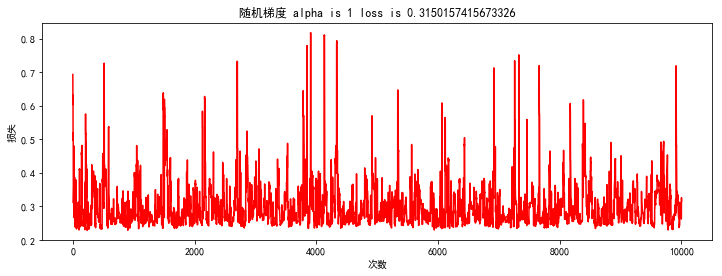

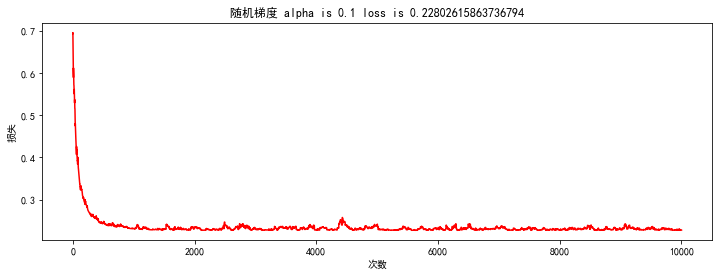

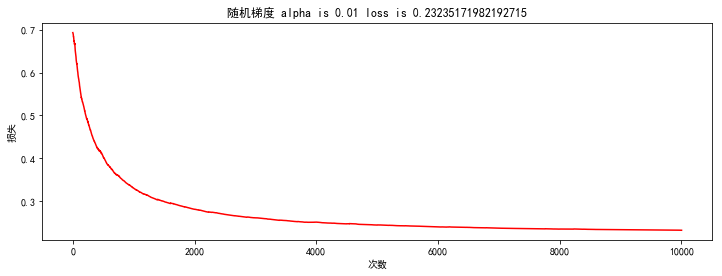

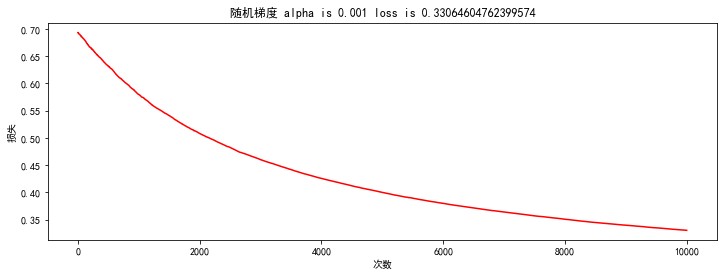

In [71]:
drawpic(scaled_data,np.array([[0,0,0]]),10000,1,1)
drawpic(scaled_data,np.array([[0,0,0]]),10000,1,0.1)
drawpic(scaled_data,np.array([[0,0,0]]),10000,1,0.01)
drawpic(scaled_data,np.array([[0,0,0]]),10000,1,0.001)

#### (学习率不变，改变迭代次数) 很直观 迭代次数越多效果损失越小

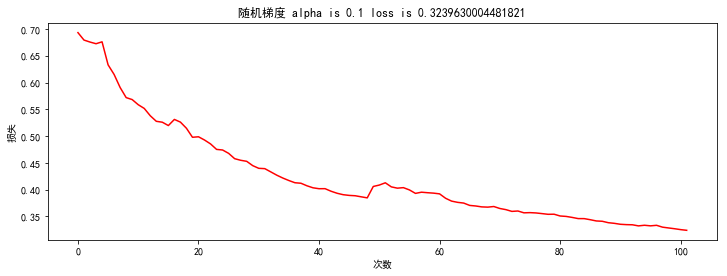

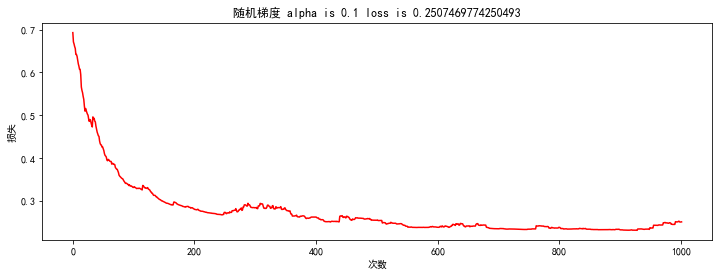

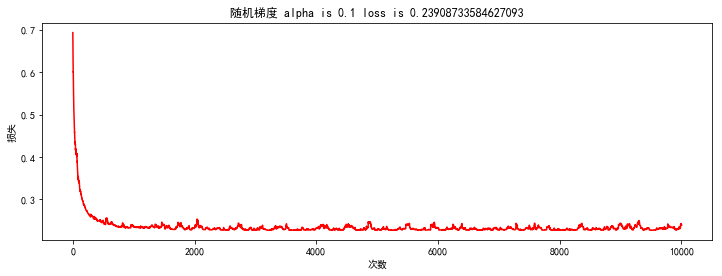

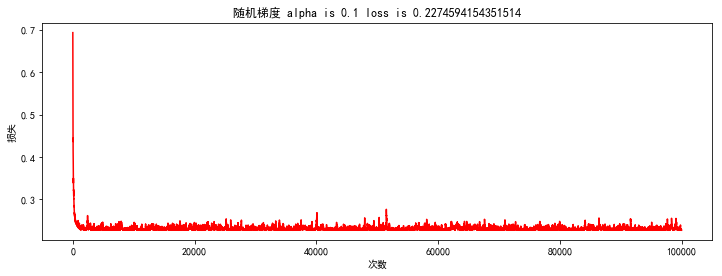

In [72]:
theta = drawpic(scaled_data,np.array([[0,0,0]]),100,1,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),1000,1,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,1,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),100000,1,0.1)

### 对比不同的梯度下降方法

### 对比随机，小批量，批量 量越损失越小，但是所需时间越长，并且变化不明显

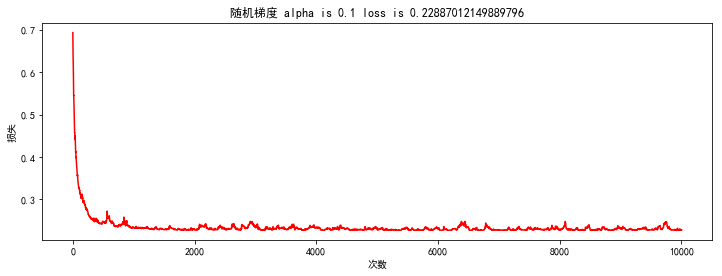

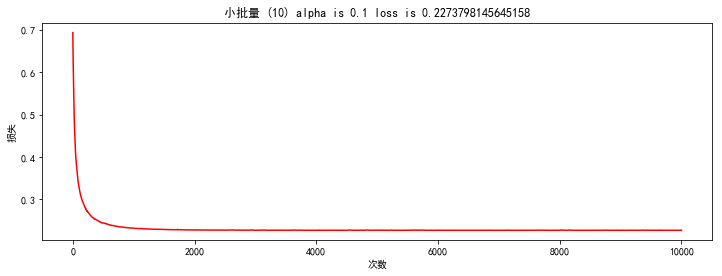

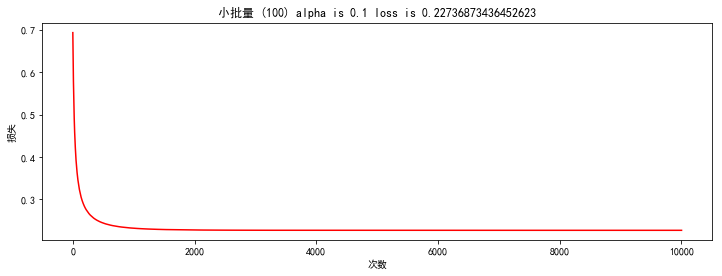

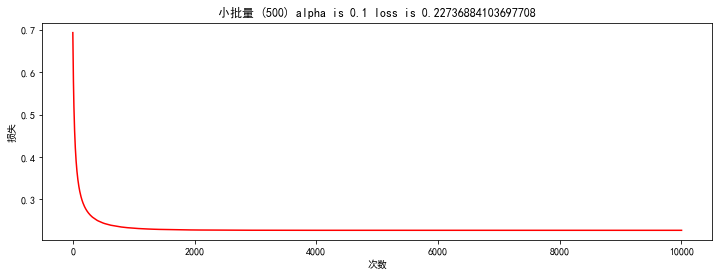

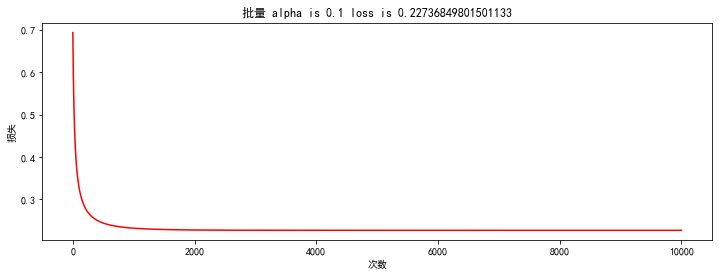

In [73]:
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,1,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,10,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,100,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,500,0.1)
theta = drawpic(scaled_data,np.array([[0,0,0]]),10000,1000,0.1)

## 精度

In [74]:
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [75]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) / len(correct))
print ('accuracy = {0}%'.format(accuracy*100))

accuracy = 90.4%


confusion [[657  41]
 [ 55 247]]
len(confusion) 2


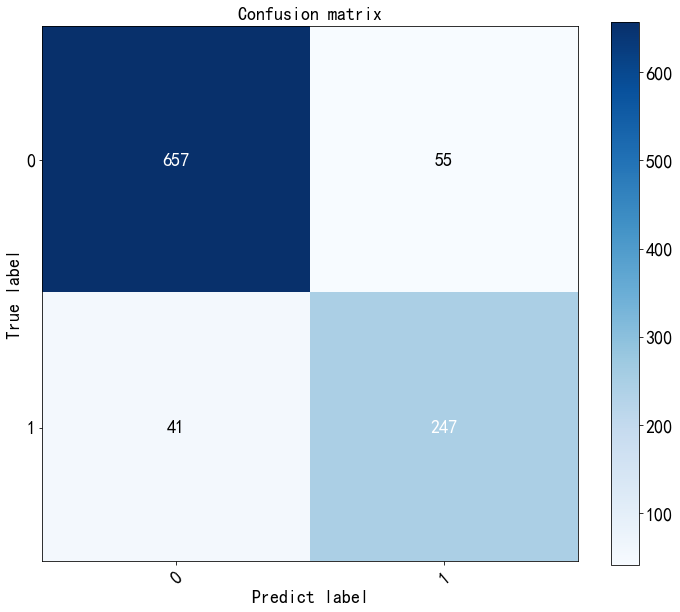

In [81]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

r1 = confusion_matrix(y, predictions)
guess = ["1","0"]
fact = [ "1","0"]
classes = list(set(fact))
# classes.sort(reverse=True)

plt.figure(figsize=(12,10))       #设置plt窗口的大小
confusion =r1
print("confusion",confusion)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
indices2 = range(3)
plt.xticks(indices, classes,rotation=40,fontsize=18)
plt.yticks([0.00,1.00], classes,fontsize=18)
plt.ylim(1.5 , -0.5)   #设置y的纵坐标的上下限

plt.title("Confusion matrix",fontdict={'weight':'1','size': 18})
#设置color bar的标签大小
cb=plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.xlabel('Predict label',fontsize=18)
plt.ylabel('True label',fontsize=18)

print("len(confusion)",len(confusion))
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        if confusion[first_index][second_index]>200:
            color="w"
        else:
            color="black"
        plt.text(first_index, second_index, confusion[first_index][second_index],fontsize=18, color = color,verticalalignment='center',horizontalalignment='center',)
plt.show()

